# Ethan Ooi | Explore the Data

## Import Libraries

In terminal:

git clone https://github.com/vys5hb/Design-Final.git

```
pip install pandas
pip install numpy
pip install matplotlib.pyplot
pip install seaborn
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub

In [2]:
path = kagglehub.dataset_download("ehallmar/nba-historical-stats-and-betting-data")
print("Path to dataset files:", path)

Path to dataset files: /Users/ethanooi/.cache/kagglehub/datasets/ehallmar/nba-historical-stats-and-betting-data/versions/1


In [3]:
# Load the CSV (betting spreads)
bets = pd.read_csv(f'{path}/nba_betting_spread.csv')
# Create filtered betting spreads dataset
bets = bets[bets['book_name'] == 'BetOnline']
# Drop unnecessary columns
bets = bets.drop(columns=['book_name', 'book_id', 'price1', 'price2']).reset_index(drop=True)

# Load the CSV (all games)
games = pd.read_csv(f'{path}/nba_games_all.csv')
# No betting data before 2007
games = games[games['season_year'] >= 2007]
# Drop unnecessary columns
games = games.drop(columns=['matchup', 'w', 'l', 'season_year', 'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 
                    'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'season'])

# Load the CSV (moneylines)
lines = pd.read_csv(f'{path}/nba_betting_money_line.csv')
# Create filtered moneyline dataset
lines = lines[lines['book_name'] == 'BetOnline']
# Drop unnecessary columns
lines = lines.drop(columns=['book_name', 'book_id']).reset_index(drop=True)

In [4]:
# Merge games & bets dataset on game_id
df = games.merge(bets[['game_id', 'spread1', 'spread2']], on='game_id', how='left')
df = df.merge(lines[['game_id', 'price1', 'price2']], on='game_id', how='inner')
# Filter the dataset to include only games where spread1 > 0, underdogs
# Drop duplicate game_ids and nulls
df = df[df['spread1'] > 0].drop_duplicates(subset=['game_id'], keep='first').dropna(subset='w_pct')
df = df[df['price1'] > 0]
# Create is_upset column: True if a team with spread1 > 0, wins
df['is_upset'] = ((df['spread1'] > 0) & (df['wl'] == 'W'))
# Remove 'Pre Season' games
df = df[df['season_type'] != 'Pre Season'].reset_index(drop=True)

# Playoffs are viewed as the start of a new win percentage in this dataset, 
# so this changes Playoff games' win percentage to their end-of-season record
# Calculate each team's regular-season win percentage
regular_season_wpct = (
    df[df['season_type'] == 'Regular Season']
    .groupby('team_id')['w_pct']
    .last()
)
# Update Playoff games' w_pct to their team's regular-season w_pct
df.loc[df['season_type'] == 'Playoffs', 'w_pct'] = df['team_id'].map(regular_season_wpct)

In [5]:
# Check the overall percentage of upsets
upset_rate = df['is_upset'].mean()
print(f'Overall Upset Rate: {upset_rate:.4%}')

Overall Upset Rate: 49.2504%


In [6]:
# Map 't' to True, 'f' to False, and handle NaN values
df['is_home'] = df['is_home'].map({'t': True, 'f': False})
df['is_home'] = df['is_home'].astype(bool)
# Group by 'is_home' and calculate upsets and games
upset_summary_dog = df.groupby('is_home').agg(
    upsets=('is_upset', 'sum'),
    games=('is_upset', 'count')
)
# Calculate proportion of upsets
upset_summary_dog['prop'] = upset_summary_dog['upsets'] / upset_summary_dog['games']
# Print the results
print(upset_summary_dog)

         upsets  games      prop
is_home                         
False      1243   4255  0.292127
True       2896   4149  0.698000


In [7]:
# Bin teams into four groups based on win percentage
df['w_pct_bin'] = pd.qcut(df['w_pct'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
# Create a new column that combines 'is_home' and 'w_pct_bin' called 'home_w_pct_bin'
df['home_w_pct_bin'] = df['is_home'].map({True: 'Home', False: 'Away'}) + ' ' + df['w_pct_bin'].astype(str)
# Group by the new 'home_w_pct_bin' column and calculate upset statistics
upset_summary = df.groupby('home_w_pct_bin').agg(
    upsets=('is_upset', 'sum'),
    games=('is_upset', 'count')
)
# Bin teams into four groups based on win percentage for additional analysis
w_pct_upset_summary = df.groupby('w_pct_bin', observed=False).agg(
    upsets=('is_upset', 'sum'),
    games=('is_upset', 'count')
)
# Calculate upset proportion
w_pct_upset_summary['prop'] = w_pct_upset_summary['upsets'] / w_pct_upset_summary['games']
# Print the results
print(w_pct_upset_summary)
# Calculate upset proportion
upset_summary['prop'] = upset_summary['upsets'] / upset_summary['games']
# Print the results
print(upset_summary)

           upsets  games      prop
w_pct_bin                         
Low           615   2112  0.291193
Mid-Low       977   2121  0.460632
Mid-High     1153   2079  0.554594
High         1394   2092  0.666348
                upsets  games      prop
home_w_pct_bin                         
Away High          282    684  0.412281
Away Low           309   1521  0.203156
Away Mid-High      302    895  0.337430
Away Mid-Low       350   1155  0.303030
Home High         1112   1408  0.789773
Home Low           306    591  0.517766
Home Mid-High      851   1184  0.718750
Home Mid-Low       627    966  0.649068


<Figure size 500x400 with 0 Axes>

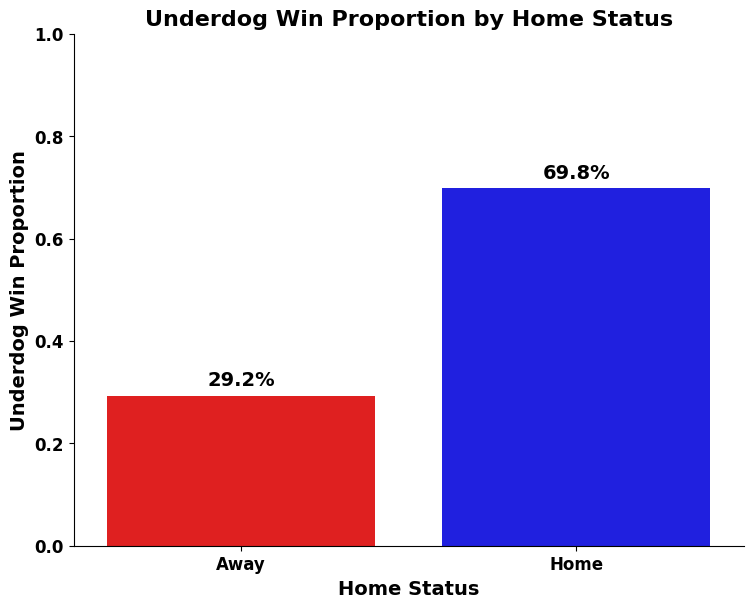

In [8]:
upset_summary_dog = upset_summary_dog.reset_index()
# Bar plot for underdog win proportion by home status
upset_summary_dog['home_status'] = upset_summary_dog['is_home'].map({True: 'Home', False: 'Away'})
plt.figure(figsize = (5,4))
g = sns.catplot(
        data=upset_summary_dog,
        x='home_status',
        y='prop',
        kind='bar',
        hue='home_status',
        palette=('red', 'blue')
)
g.figure.set_size_inches(8, 6)
ax = g.ax

# Add annotations above each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + .02,
        f'{height:.1%}',
        ha='center',
        fontsize=14,
        fontweight='bold'
    )
    
# Labels & Formatting
ax.set_title("Underdog Win Proportion by Home Status", fontsize=16, fontweight='bold')
ax.set_xlabel('Home Status', fontsize=14, fontweight='bold' )
ax.set_ylabel("Underdog Win Proportion", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
plt.show()

/var/folders/2t/0j9q5vjs2_l2pp_7wflhtr3w0000gn/T/ipykernel_52996/412249890.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


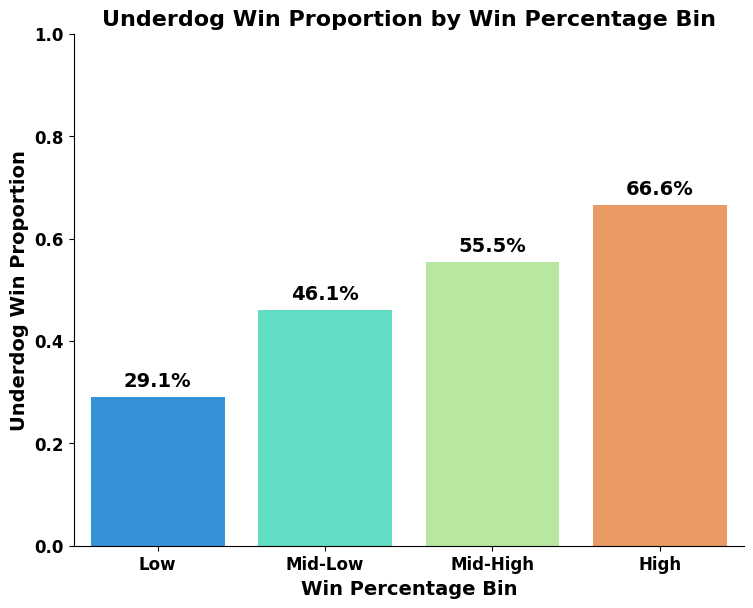

In [9]:
# Reset the index
w_pct_upset_summary = w_pct_upset_summary.reset_index()
# Bar plot for underdog win proportion by win percentage bin
g = sns.catplot(
        data=w_pct_upset_summary,
        x='w_pct_bin', 
        y='prop',
        kind='bar',
        palette='rainbow'
)

g.figure.set_size_inches(8, 6)
ax = g.ax

# Add annotations above each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + .02,
        f'{height:.1%}',
        ha='center',
        fontsize=14,
        fontweight='bold'
    )
    
# Labels & Formatting
ax.set_title("Underdog Win Proportion by Win Percentage Bin", fontsize=16, fontweight='bold')
ax.set_xlabel("Win Percentage Bin", fontsize=14, fontweight='bold')
ax.set_ylabel("Underdog Win Proportion", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
plt.show()

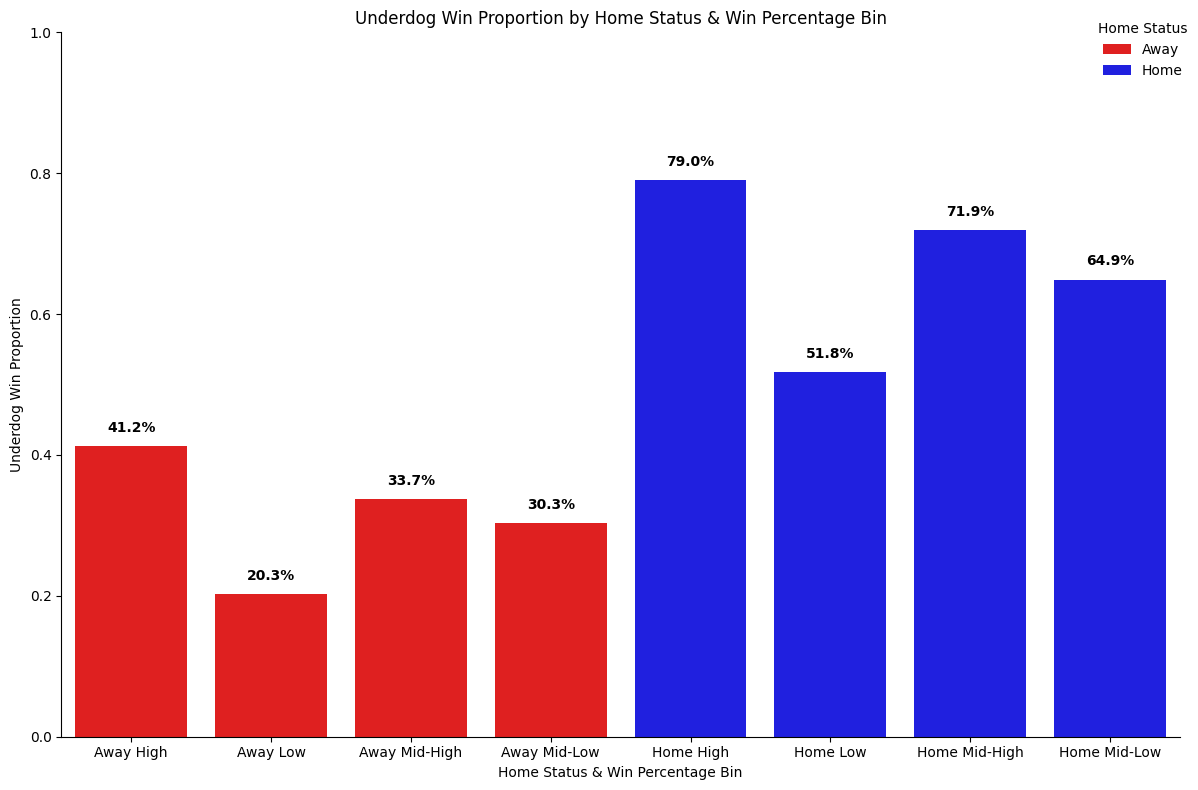

In [10]:
# Reset the index
upset_summary = upset_summary.reset_index()
# Extract "Home" or "Away" from the `home_w_pct_bin` column
upset_summary['home_status'] = upset_summary['home_w_pct_bin'].apply(lambda x: 'Home' if 'Home' in x else 'Away')
# Bar Plot of Underdog Win Proportion by Home Status & Win Percentage Bin
g = sns.catplot(
        data=upset_summary, 
        x='home_w_pct_bin', 
        y='prop', 
        kind='bar',
        hue='home_status', 
        palette={'Home': 'blue', 'Away': 'red'}
)

g.figure.set_size_inches(12, 8)
ax = g.ax

# Add annotations above each bar
for p in ax.patches:
    height = p.get_height()
    if height > .01:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + .02,
            f'{height:.1%}',
            ha='center',
            fontweight='bold'
        )

# Labels & Formatting
ax.set_xlabel("Home Status & Win Percentage Bin")
ax.set_ylabel("Underdog Win Proportion")
ax.set_title("Underdog Win Proportion by Home Status & Win Percentage Bin")
ax.set_ylim(0, 1)
g._legend.set_title("Home Status")
g._legend.set_bbox_to_anchor((1, .925))
plt.tight_layout()
plt.show()

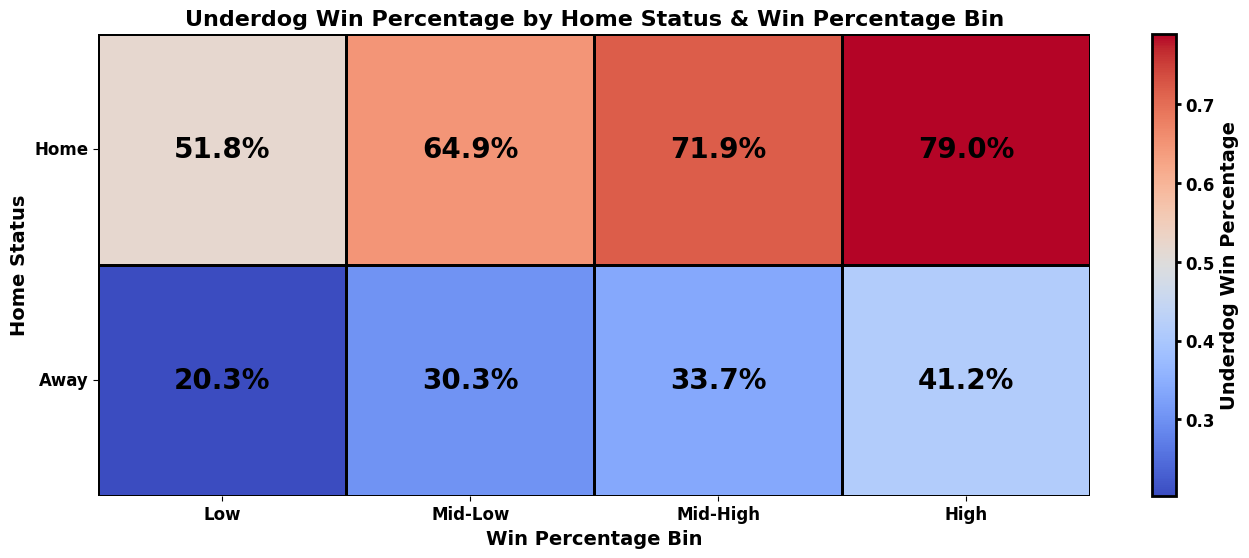

In [11]:
# Extract bin level from 'home_w_pct_bin'
upset_summary['w_pct_bin'] = (
    upset_summary['home_w_pct_bin']
    .str.extract(r'(Low|Mid-Low|Mid-High|High)')[0]
)
# Set bin order
bin_order = ['Low', 'Mid-Low', 'Mid-High', 'High']

# Home/Away on y-axis, Win% bins on x-axis
heat = (
    upset_summary
    .pivot(index='home_status', columns='w_pct_bin', values='prop')
    .reindex(index=['Home', 'Away'], columns=bin_order)
)

# Heatmap of underdog win percentage by home status and win percentage bin
# Same as the bar plot, formatted different
plt.figure(figsize=(16, 6))
sns.heatmap(
    heat,
    annot=True,
    fmt=".1%",
    cmap='coolwarm',
    linecolor='black',
    linewidths=1,
    annot_kws={'size': 20,
               'fontweight': 'bold',
               'color': 'black'},
    cbar_kws={'label': 'Underdog Win Percentage'}
)

# Labels and formatting
plt.title('Underdog Win Percentage by Home Status & Win Percentage Bin', fontsize=16, fontweight='bold')
plt.xlabel('Win Percentage Bin', fontsize=14, fontweight='bold')
plt.ylabel('Home Status', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold', rotation=0)
# Get current axes and cbar
ax = plt.gca()
cbar = ax.collections[0].colorbar
cbar.set_label('Underdog Win Percentage',fontsize=14,fontweight='bold')
cbar.outline.set_linewidth(2)
# Bold cbar tick labels
cbar.ax.tick_params(labelsize=12, width=2)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontweight('bold')
plt.show()

In [12]:
# Moneyline profit calculation
def calculate_profit(bet, line, games, wins):
    win_profit = (line / 100) * bet
    losses = games - wins
    return win_profit - losses * bet
# Calculate profit for all different scenarios of flat bets
total_line = df[(df['wl'] == 'W')]['price1'].sum()
prof_base = calculate_profit(1, total_line, len(df), len(df[df['wl'] == 'W']))

total_line_home = df[(df['wl'] == 'W') & (df['is_home'] == True)]['price1'].sum()
prof_home = calculate_profit(1, total_line_home, len(df[df['is_home'] == True]), len(df[(df['wl'] == 'W') & (df['is_home'] == True)]))

total_line_away = df[(df['wl'] == 'W') & (df['is_home'] == False)]['price1'].sum()
prof_away = calculate_profit(1, total_line_away, len(df[df['is_home'] == False]), len(df[(df['wl'] == 'W') & (df['is_home'] == False)]))

total_line_wpct_high = df[(df['wl'] == 'W') & (df['w_pct_bin'] == 'High')]['price1'].sum()
prof_high = calculate_profit(1, total_line_wpct_high, len(df[df['w_pct_bin'] == 'High']), len(df[(df['wl'] == 'W') & (df['w_pct_bin'] == 'High')]))

total_line_wpct_midhigh = df[(df['wl'] == 'W') & (df['w_pct_bin'] == 'Mid-High')]['price1'].sum()
prof_midhigh = calculate_profit(1, total_line_wpct_midhigh, len(df[df['w_pct_bin'] == 'Mid-High']), len(df[(df['wl'] == 'W') & (df['w_pct_bin'] == 'Mid-High')]))

total_line_wpct_midlow = df[(df['wl'] == 'W') & (df['w_pct_bin'] == 'Mid-Low')]['price1'].sum()
prof_midlow = calculate_profit(1, total_line_wpct_midlow, len(df[df['w_pct_bin'] == 'Mid-Low']), len(df[(df['wl'] == 'W') & (df['w_pct_bin'] == 'Mid-Low')]))

total_line_wpct_low = df[(df['wl'] == 'W') & (df['w_pct_bin'] == 'Low')]['price1'].sum()
prof_low = calculate_profit(1, total_line_wpct_low, len(df[df['w_pct_bin'] == 'Low']), len(df[(df['wl'] == 'W') & (df['w_pct_bin'] == 'Low')]))

In [13]:
# Track exact profits for each strategy
profits = [prof_base, prof_home, prof_away, prof_high, prof_midhigh, prof_midlow, prof_low]
games = [len(df), len(df[df['is_home'] == True]), len(df[df['is_home'] == False]), len(df[df['w_pct_bin'] == 'High']), len(df[df['w_pct_bin'] == 'Mid-High']), len(df[df['w_pct_bin'] == 'Mid-Low']), len(df[df['w_pct_bin'] == 'Low'])]
labels = ['Base', 'Home', 'Away', 'High W%', 'Mid-High W%', 'Mid-Low W%', 'Low W%']
for i, j, k in zip(profits, games, labels):
    print(f'{k} Profit: ${i:.2f} in {j} games betting $1 on the underdog.')

Base Profit: $7613.35 in 8404 games betting $1 on the underdog.
Home Profit: $7765.83 in 4149 games betting $1 on the underdog.
Away Profit: $-152.48 in 4255 games betting $1 on the underdog.
High W% Profit: $4049.18 in 2092 games betting $1 on the underdog.
Mid-High W% Profit: $2278.89 in 2079 games betting $1 on the underdog.
Mid-Low W% Profit: $1248.59 in 2121 games betting $1 on the underdog.
Low W% Profit: $36.69 in 2112 games betting $1 on the underdog.


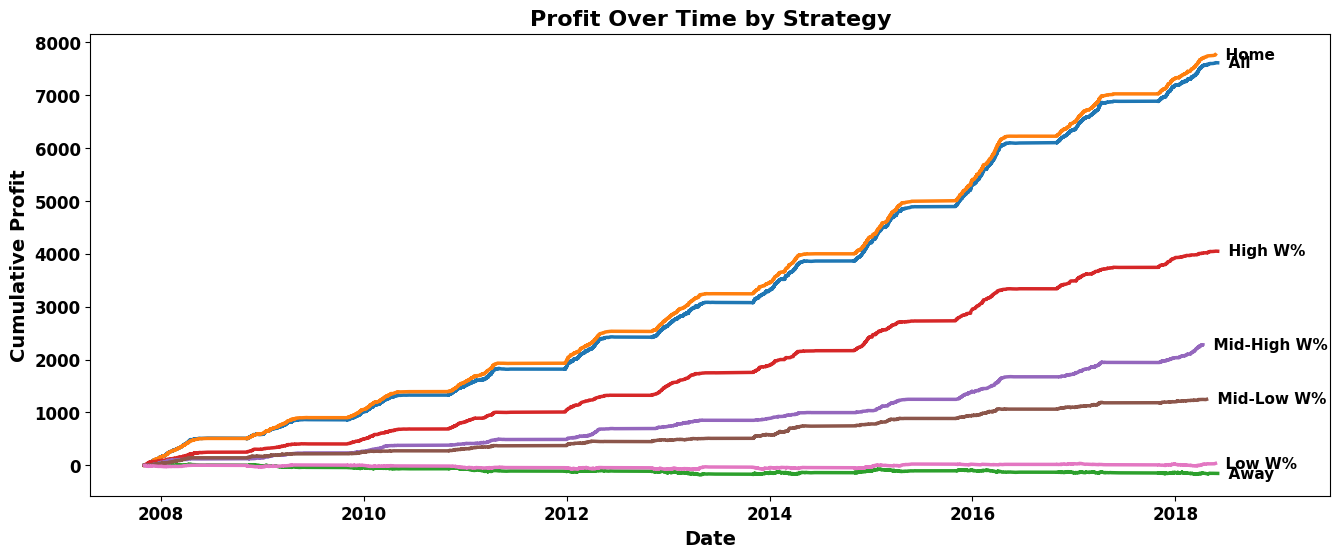

In [14]:
# Order data by game date
df = df.copy()
df['game_date'] = pd.to_datetime(df['game_date'])
df = df.sort_values('game_date')

# Returns a dataframe with cumulative profit column
def add_cum_profit(d):
    d = d.sort_values('game_date').copy()
    d['profit'] = np.where(d['wl'] == 'W', d['price1'] / 100, -1.0)
    d['cum_profit'] = d['profit'].cumsum()
    return d

# Different betting strategies
strategies = {
    "All": lambda x: x,
    "Home": lambda x: x[x['is_home']],
    "Away": lambda x: x[~x['is_home']],
    "High W%": lambda x: x[x['w_pct_bin'] == 'High'],
    "Mid-High W%": lambda x: x[x['w_pct_bin'] == 'Mid-High'],
    "Mid-Low W%": lambda x: x[x['w_pct_bin'] == 'Mid-Low'],
    "Low W%": lambda x: x[x['w_pct_bin'] == 'Low']
}

# Plotting line plot of cumulative profit over time for each strategy
fig, ax = plt.subplots(figsize=(16, 6))

# Iterate through each strategy and plot all lines on same plot
for name, f in strategies.items():
    d = f(df)
    if len(d) == 0:
        continue
    d = add_cum_profit(d)
    ax.plot(d['game_date'], d['cum_profit'], linewidth=2.5)
    # Strategy annotation
    ax.text(d['game_date'].iloc[-1], d['cum_profit'].iloc[-1], f"  {name}", va='center', fontsize=11, fontweight='bold')

# Labels & formatting
plt.title('Profit Over Time by Strategy', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Profit', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
# Extend x-axis to the right for annotations
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin, xmax + (xmax - xmin) * 0.05)
plt.show()
